In [12]:
pip install --upgrade yfinance==0.2.54

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [16]:
import yfinance as yf
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm  # for CAPM and Fama-French regressions
import pandas_datareader
import matplotlib.pyplot as plt
from arch import arch_model
import itertools

In [17]:
def garch_aic_sel(returns):
    # Define grids for model parameters
    mean_models = ['Constant', 'AR']
    vol_models = ['GARCH', 'EGARCH']
    dists = ['normal', 't']

    results = []

    for mean in mean_models:
        for vol in vol_models:
            for dist in dists:
                lags = 1 if mean == 'AR' else 0
                
                # -----------------------------
                # Fit the full model on the dataset
                model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res = model.fit(disp='off')

                # -----------------------------
                # Get the AIC from the model
                aic = res.aic
                results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': aic})

    # Find the best model based on AIC
    results_df = pd.DataFrame(results)
    best_model = results_df.loc[results_df['aic'].idxmin()]
    return best_model['mean'], best_model['vol'], best_model['dist']

In [18]:
#Combined Code

# ----------------------------
# 1. Load Fama–French Factor Data
# ----------------------------
ff = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=4, header=0, names=['Date','Mkt-RF','SMB','HML','RF']) # Added names and header, skiprows to 4
# Date is in yyyymmdd format, convert it:
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m')
ff = ff.set_index('Date')
# Convert factor returns from percentages to decimals
ff = ff.astype(float) / 100

# ----------------------------
# 2. Forecast Factors using optimal GARCH(1,1) on 100x Scaled Data
# ----------------------------
forecast_results = {}
factors = ['Mkt-RF', 'SMB', 'HML']

for factor in factors:
    series_ = ff[factor].dropna()
    # convert to log-returns
    series = np.log(1 + series_)
    # Scale the series by 100 to stabilize the GARCH estimation
    mean, vol, dist = garch_aic_sel(100 * series)
    am = arch_model(100 * series, mean=mean, vol=vol, p=1, q=1, dist=dist)
    res = am.fit(disp='off')

    # Forecast one period ahead (next month)
    forecast = res.forecast(horizon=1, reindex=False)

     # Scale back forecasted values
    next_mean_scaled = forecast.mean.iloc[-1, 0] / 100
    next_variance_scaled = forecast.variance.iloc[-1, 0] / (100 ** 2)

    # Convert log-return forecast to simple return forecast (log-normal transformation)
    next_step_mean = np.exp(next_mean_scaled + next_variance_scaled / 2) - 1
    next_step_variance = (np.exp(next_variance_scaled) - 1) * np.exp(2 * next_mean_scaled + next_variance_scaled)

    forecast_results[factor] = {'next_step_mean': next_step_mean,
                                'next_step_variance': next_step_variance}
    print(f"Forecast for {factor} (next period): Mean = {next_step_mean}, Variance = {next_step_variance}")

# ----------------------------
# 3. Download Stock Data and Run Regressions
# ----------------------------
tickers = ["AAPL", "MSFT", "GOOG", "BRK-B", "JPM", "JNJ", "V", "PG"]
prices = yf.download(tickers, start='2009-12-31', end='2024-12-31', interval='1mo', auto_adjust=True)['Close']

returns = prices.pct_change().dropna()

# Align dates of stock returns and factor data
common_dates = returns.index.intersection(ff.index)
returns = returns.loc[common_dates]
ff = ff.loc[common_dates]

# Run OLS regressions to estimate factor loadings and obtain residual variances.
results = {}   # to store regression outputs
coeffs = {}    # to store estimated coefficients for each ticker

for ticker in tickers:
    df = pd.DataFrame({'r': returns[ticker]})
    df = df.join(ff[['Mkt-RF', 'SMB', 'HML', 'RF']])
    # Compute excess returns: r - RF
    df['excess'] = df['r'] - df['RF']

    # Independent variables are the three factors (with constant)
    X = df[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess']

    model = sm.OLS(y, X).fit()
    results[ticker] = model
    coeffs[ticker] = {
         'alpha': model.params['const'],
         'Mkt-RF': model.params['Mkt-RF'],
         'SMB': model.params['SMB'],
         'HML': model.params['HML']
    }

    print(f"\nRegression results for {ticker}:\n", model.summary())

# ----------------------------
# 4. Forecast Next Day Expected Returns (r_{i,t+1})
# ----------------------------
forecast_r = {}
for ticker in tickers:
    # r_{i,t+1} = alpha_i + beta_i,Mkt * (forecast_Mkt/100) + beta_i,SMB * (forecast_SMB/100) + beta_i,HML * (forecast_HML/100)
    alpha = coeffs[ticker]['alpha']
    r_forecast = alpha
    for factor in factors:
        beta = coeffs[ticker][factor]
        factor_mean = forecast_results[factor]['next_step_mean']
        r_forecast += beta * factor_mean
    forecast_r[ticker] = r_forecast
    print(f"\nForecasted r_{ticker}, t+1: {r_forecast}")

# ----------------------------
# 5. Calculate Total Forecast Error Variance for r_{i,t+1}
# ----------------------------
# Total variance = sum_j (beta_{ij}^2 * (sigma_{j, forecast}^2 / 100^2)) + sigma^2_reg,
# where sigma^2_reg is the mean squared error (residual variance) from the regression.
forecast_error = {}
for ticker in tickers:
    beta_squared_sum = 0
    for factor in factors:
        beta = coeffs[ticker][factor]
        factor_variance = forecast_results[factor]['next_step_variance']
        beta_squared_sum += (beta**2) * factor_variance

    sigma2_reg = results[ticker].mse_resid  # regression residual variance
    total_variance = beta_squared_sum + sigma2_reg
    forecast_error[ticker] = total_variance
    print(f"Total forecast error variance for {ticker}: {total_variance}")


Forecast for Mkt-RF (next period): Mean = 0.01016400289991215, Variance = 0.0016505269945385483
Forecast for SMB (next period): Mean = 0.0006864029404214378, Variance = 0.0011731800077627638


[**********************50%                       ]  4 of 8 completed

Forecast for HML (next period): Mean = 0.0023962797673686698, Variance = 0.0008347280333907814


[*********************100%***********************]  8 of 8 completed


Regression results for AAPL:
                             OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     44.68
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           1.73e-21
Time:                        16:37:18   Log-Likelihood:                 256.44
No. Observations:                 179   AIC:                            -504.9
Df Residuals:                     175   BIC:                            -492.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095

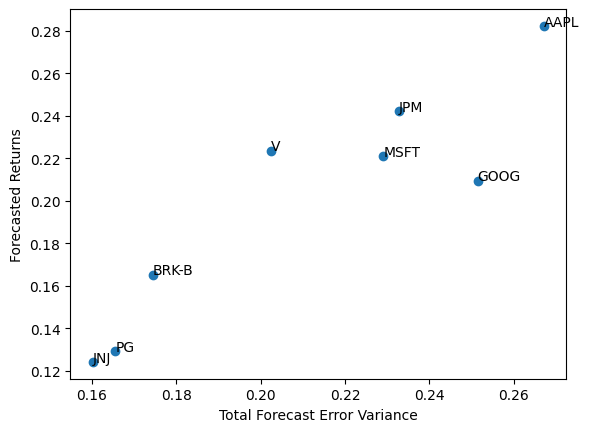

In [19]:
annualizer = 12

annualized_return = {ticker: (forecast_r[ticker] + ff['RF'].iloc[-1]) * annualizer for ticker in tickers}
annualized_volatility = {ticker: np.sqrt(forecast_error[ticker]) * np.sqrt(annualizer) for ticker in tickers}

plt.scatter(annualized_volatility.values(), annualized_return.values())
# use ticker to label scatter plots
for ticker in tickers:
    plt.text(annualized_volatility[ticker], annualized_return[ticker], ticker)
plt.xlabel('Total Forecast Error Variance')
plt.ylabel('Forecasted Returns')
plt.show()

In [20]:
from pypfopt import EfficientFrontier, risk_models

# calculate the optimal max sharpe portfolio using the forecasted mean return as expected returns and the empirical covariance for risk
mu = pd.Series(annualized_return)
S = risk_models.sample_cov(prices, frequency=12)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=ff['RF'].iloc[-1])
ef.portfolio_performance(verbose=True, risk_free_rate=ff['RF'].iloc[-1])

Expected annual return: 22.7%
Annual volatility: 12.6%
Sharpe Ratio: 1.78


(np.float64(0.2273164957231772),
 np.float64(0.12582239292745445),
 np.float64(1.7772392538433757))

<Axes: >

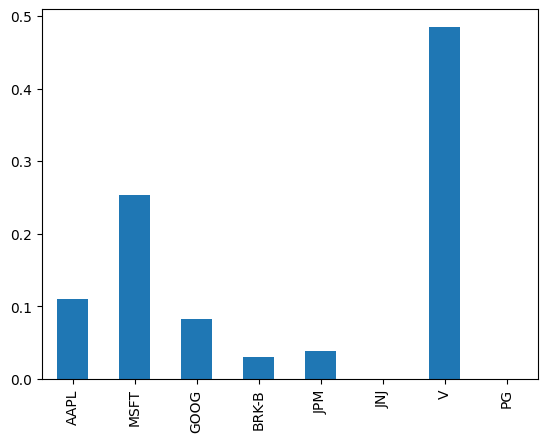

In [21]:
# plot the weights of the optimal portfolio
weights = pd.Series(weights)
weights.plot(kind='bar')


In [22]:
weights*100

AAPL     11.027932
MSFT     25.373520
GOOG      8.276018
BRK-B     2.983290
JPM       3.812893
JNJ       0.000000
V        48.526348
PG        0.000000
dtype: float64